In [1]:
import pandas as pd
import numpy as np

# to train:
from sklearn.model_selection import ParameterGrid
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# to evaluate
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
#pd.set_option("display.max_colwidth",200)
pd.options.display.float_format = '{:,.4f}'.format

## Read in data


In [2]:
df_file1 = pd.read_csv("../hw1/SST-2/train.tsv",delimiter="\t")
df_file2 = pd.read_csv("../hw1/SST-2/dev.tsv",delimiter="\t")
df_all = pd.concat([df_file1, df_file2],axis=0).sample(frac=1.0, random_state=0).copy().reset_index(drop=True)

n_texts = len(df_all)

print(f"Target rate: {df_all.label.mean():.2%}")

print("Sample of training set:")
df_all.head(5)

Target rate: 55.72%
Sample of training set:


,sentence,label
0,before the plot kicks into gear,1
1,see this terrific film,1
2,'s an excellent 90-minute film,1
3,ensemble cast,1
4,is to be viewed and treasured for its extraord...,1


In [3]:
traindev_index, test_index = train_test_split(df_all.index, test_size=0.2)
train_index, valid_index = train_test_split(traindev_index, test_size=0.1)

print(f"Train size:  {len(train_index)} -> {len(train_index)/n_texts:0.1%}")
print(f"Test size:   {len(test_index)} -> {len(test_index)/n_texts:0.1%}")
print(f"Valid. size: {len(valid_index)} -> {len(valid_index)/n_texts:0.1%}")

Train size:  49118 -> 72.0%
Test size:   13645 -> 20.0%
Valid. size: 5458 -> 8.0%



## Training a Text Classifier

Scikit-learn provides the `Pipeline` class to tie together steps in model training

In [4]:
def fit_pipeline(*, texts, labels, min_df=1, max_df=0.1, ngram_range=(1,1), alpha=1.0):
    """ Train a text classifier model given input hyperparameters:
      - CountVectorizer: min_df, max_df, ngram_range
      - NaiveBayes:      alpha
    """

    # Pipeline Step 1: texts -> BOW vectors
    vectorizer = CountVectorizer(min_df=min_df, 
                                 max_df=max_df,
                                 stop_words="english",
                                 ngram_range=ngram_range)

    # Pipeline Step 2: document vectors -> model score
    model = MultinomialNB(alpha=alpha)

    pipeline = Pipeline(steps=[
        ("vectorizer",vectorizer),
        ("model",model)
    ])

    pipeline.fit(texts,labels)

    return pipeline

# convert to numpy array/matrix
train_texts = df_all.loc[train_index].sentence.values
train_labels = df_all.loc[train_index].label.values

pipeline = fit_pipeline(texts=train_texts, labels=train_labels)
pipeline


Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.1, stop_words='english')),
                ('model', MultinomialNB())])

In [5]:
# individual components are still accessible:
print("Vocabulary size:", len(pipeline[0].vocabulary_))

Vocabulary size: 13891


In [6]:
valid_texts = df_all.loc[valid_index].sentence.values
Valid_labels = df_all.loc[valid_index].label.values

pipeline.predict(valid_texts)

array([0, 1, 1, ..., 0, 0, 1])

In [7]:
pipeline.predict_proba(valid_texts)

array([[9.99998616e-01, 1.38421454e-06],
       [5.58242945e-03, 9.94417571e-01],
       [1.36731273e-03, 9.98632687e-01],
       ...,
       [9.99088360e-01, 9.11639907e-04],
       [8.90962111e-01, 1.09037889e-01],
       [3.48869256e-02, 9.65113074e-01]])

In [8]:
valid_labels = df_all.loc[valid_index].label.values
valid_preds = pipeline.predict(valid_texts)

print(f"% of rows flagged by model: {valid_preds.mean():.2%}")

print("Confusion matrix:")
pd.crosstab(
    pd.Series(valid_preds,name="y_pred"), 
    pd.Series(valid_labels, name="y_true"),
    margins=True,
    normalize=True
)

% of rows flagged by model: 56.30%
Confusion matrix:


y_true,0,1,All
y_pred,,,
0,0.3725,0.0645,0.4370
1,0.0729,0.4901,0.5630
All,0.4454,0.5546,1.0000


In [9]:
valid_precision = precision_score(valid_labels, valid_preds)
valid_recall = recall_score(valid_labels, valid_preds)
valid_f1 = f1_score(valid_labels, valid_preds)

print(f"Precision: {valid_precision:.2f}")
print(f"Recall:    {valid_recall:.2f}")
print(f"F1:        {valid_f1:.2f}")


Precision: 0.87
Recall:    0.88
F1:        0.88


## Updating our threshold

What if we want to be "conservative" and only flag the top 10%

In [10]:
valid_scores = pipeline.predict_proba(valid_texts)[:,1]
print(valid_scores.shape)

# what score flags only top 10%?
threshold = np.quantile(valid_scores, 0.9)

print(threshold)
new_preds = (valid_scores>threshold)
print(new_preds.mean())

valid_precision = precision_score(valid_labels, new_preds)
valid_recall = recall_score(valid_labels, new_preds)
valid_f1 = f1_score(valid_labels, new_preds)

print(f"\nPrecision: {valid_precision:.2f}")
print(f"Recall:    {valid_recall:.2f}")
print(f"F1:        {valid_f1:.2f}")

(5458,)
0.9980752056829273
0.10003664345914254

Precision: 0.98
Recall:    0.18
F1:        0.30


# Testing multiple models

In [11]:
param_grid = ParameterGrid({
    "min_df":     [1,10],
    "max_df":     [0.01, 0.1],
    "ngram_range":[(1,1),(1,2),(1,3)], 
})


print(f"# of grid points: {len(param_grid)}")

def get_metrics(pipeline, texts, labels):
    preds = pipeline.predict(texts)
    
    pr = precision_score(labels, preds)
    re = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    return {
        "precision":precision_score(labels, preds),
        "recall":recall_score(labels, preds),
        "f1":f1_score(labels, preds)
    }

results_arr = []

for gridpt in param_grid:
    print(gridpt)
    trained = fit_pipeline(texts=train_texts, labels=train_labels, **gridpt)
    metrics = get_metrics(trained, valid_texts, valid_labels)
    
   
    # save hyperparams and results
    combined_data = {**gridpt, **metrics, "trained":trained}
    # check for overfitting
    combined_data['f1_train'] = f1_score(train_labels, trained.predict(train_texts))

    # vocab size
    combined_data['K'] = len(trained[0].vocabulary_)
    
    results_arr.append(combined_data)
 

df_results = pd.DataFrame(results_arr).sort_values("f1", ascending=False)
df_results.drop("trained",axis=1)

# of grid points: 12
{'max_df': 0.01, 'min_df': 1, 'ngram_range': (1, 1)}
{'max_df': 0.01, 'min_df': 1, 'ngram_range': (1, 2)}
{'max_df': 0.01, 'min_df': 1, 'ngram_range': (1, 3)}
{'max_df': 0.01, 'min_df': 10, 'ngram_range': (1, 1)}
{'max_df': 0.01, 'min_df': 10, 'ngram_range': (1, 2)}
{'max_df': 0.01, 'min_df': 10, 'ngram_range': (1, 3)}
{'max_df': 0.1, 'min_df': 1, 'ngram_range': (1, 1)}
{'max_df': 0.1, 'min_df': 1, 'ngram_range': (1, 2)}
{'max_df': 0.1, 'min_df': 1, 'ngram_range': (1, 3)}
{'max_df': 0.1, 'min_df': 10, 'ngram_range': (1, 1)}
{'max_df': 0.1, 'min_df': 10, 'ngram_range': (1, 2)}
{'max_df': 0.1, 'min_df': 10, 'ngram_range': (1, 3)}


,max_df,min_df,ngram_range,precision,recall,f1,f1_train,K
7,0.1000,1,"(1, 2)",0.8920,0.8926,0.8923,0.9297,65126
8,0.1000,1,"(1, 3)",0.8923,0.8900,0.8912,0.9310,113170
2,0.0100,1,"(1, 3)",0.8914,0.8890,0.8902,0.9304,113146
1,0.0100,1,"(1, 2)",0.8894,0.8903,0.8899,0.9286,65102
6,0.1000,1,"(1, 1)",0.8705,0.8837,0.8770,0.9028,13891
0,0.0100,1,"(1, 1)",0.8641,0.8778,0.8709,0.8979,13867
10,0.1000,10,"(1, 2)",0.8125,0.8774,0.8437,0.8653,6459
11,0.1000,10,"(1, 3)",0.8125,0.8774,0.8437,0.8654,6946
9,0.1000,10,"(1, 1)",0.8101,0.8781,0.8427,0.8630,4813
4,0.0100,10,"(1, 2)",0.8078,0.8761,0.8406,0.8617,6435


In [20]:
selected_pipeline = df_results.loc[7,"trained"]

print("Train metrics", get_metrics(
    selected_pipeline,
    texts=df_all.loc[train_index].sentence, 
    labels=df_all.loc[train_index].label)
)

print("Valid metrics", get_metrics(
    selected_pipeline,
    texts=df_all.loc[valid_index].sentence, 
    labels=df_all.loc[valid_index].label)
)

Train metrics {'precision': 0.9322593666287475, 'recall': 0.9272236213000474, 'f1': 0.9297346752058553}
Valid metrics {'precision': 0.8920435787388578, 'recall': 0.8926329699372316, 'f1': 0.892338177014531}


Text(0.5, 1.0, 'Frequencey distribution: Model score by True label')

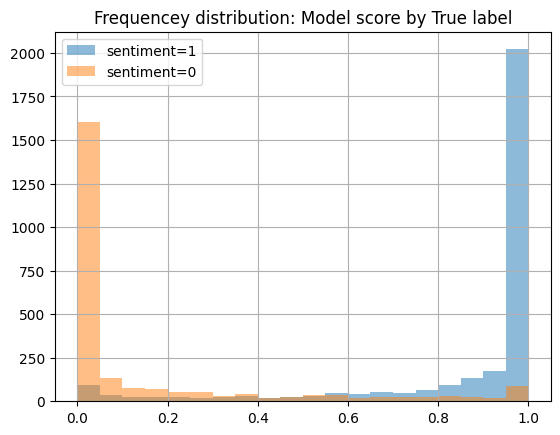

In [21]:
df_all['score'] = selected_pipeline.predict_proba(df_all.sentence)[:,1]
df_valid = df_all.loc[valid_index]


df_valid[df_valid.label==1].score.hist(bins=20, alpha=0.5,label="sentiment=1")
df_valid[df_valid.label==0].score.hist(bins=20, alpha=0.5,label="sentiment=0")

plt.legend()
plt.title("Frequencey distribution: Model score by True label")

## Key indicators

"Can you show me **why** it was given a high score?"

In [22]:
selected_vect = selected_pipeline[0]
vocab = sorted([v for v in selected_vect.vocabulary_.keys()], key=selected_vect.vocabulary_.get)
print(len(vocab))

selected_model = selected_pipeline[1]
log_probs = selected_model.feature_log_prob_[1:].reshape(-1)
v_to_logprob = {v:score for v,score in zip(vocab,log_probs)}

top_vocab = sorted(vocab, key=v_to_logprob.get, reverse=True)[:10]
print(top_vocab)

65126
['film', 'movie', 'good', 'funny', 'story', 'best', 'like', 'comedy', 'life', 'love']


In [23]:
top_vocab_negative = sorted(vocab, key=v_to_logprob.get, reverse=False)[:10]
print(top_vocab_negative)

['10 complete', '10 seconds', '10 set', '10 times', '10 years', '100 missing', '101 class', '101 study', '105', '105 minutes']


In [24]:
## Threshold Free Metric


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


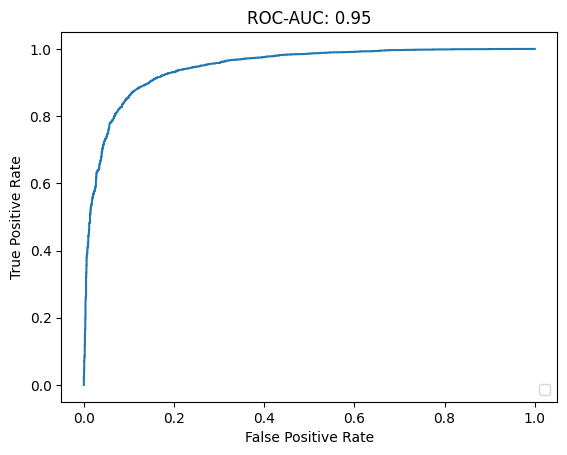

In [25]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

valid_labels = df_all.loc[valid_index].label.values

valid_scores = df_all.loc[valid_index].score.values

fpr, tpr, _ = roc_curve(valid_labels, valid_scores, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

roc_auc = roc_auc_score(valid_labels, valid_scores)
_=plt.title(f"ROC-AUC: {roc_auc:.2f}")

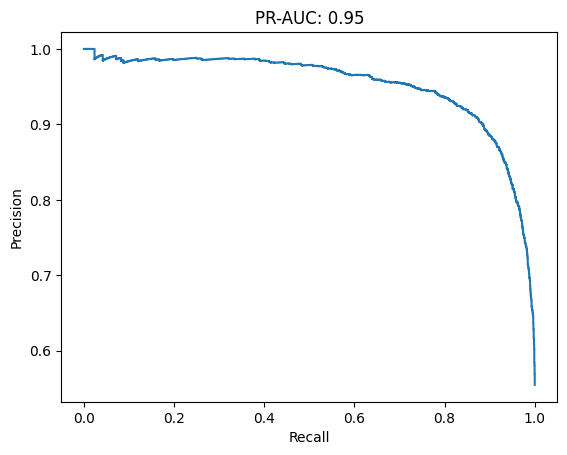

In [26]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
p, r, _ = precision_recall_curve(valid_labels, valid_scores)
pr_display = PrecisionRecallDisplay(p,r).plot()
_=plt.title("Precision-Recall curve")
_=plt.title(f"PR-AUC: {auc(r,p):.2f}")

## Considering both classes  

`classification_report` computes P+R+F1 metrics on all classes (here, positive and negative)

In [27]:


from sklearn.metrics import  classification_report
print(classification_report(valid_labels, valid_preds))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2431
           1       0.87      0.88      0.88      3027

    accuracy                           0.86      5458
   macro avg       0.86      0.86      0.86      5458
weighted avg       0.86      0.86      0.86      5458



## Error analysis

In [33]:
pd.set_option("display.max_colwidth",200)

df_all.loc[valid_index].query("(label==1) and (score<0.4)").sample(10, random_state=0)

,sentence,label,score
45877,epiphany,1,0.2387
66625,he 's making dog day afternoon with a cause,1,0.0019
52474,goes right,1,0.3117
51170,"may take its sweet time to get wherever it 's going , but if you have the patience for it , you wo n't feel like it 's wasted yours",1,0.1194
30249,of a balanced film that explains the zeitgeist that is the x games,1,0.0122
12131,does n't drag an audience down,1,0.0603
6774,"if not a home run , then at least",1,0.3412
26780,seem as cleverly plotted as the usual suspects,1,0.0044
59106,the movie rising above similar fare,1,0.2058
33274,fleshed-out enough to build any interest,1,0.0197


In [34]:
df_all.loc[valid_index].query("(label==0) and (score>0.6)").sample(10, random_state=0)

,sentence,label,score
9776,farcically bawdy,0,0.9637
56892,chokes on its own depiction of upper-crust decorum .,0,0.8754
17829,topics that could make a sailor blush,0,0.9434
50863,neither light nor magical enough to bring off this kind of whimsy,0,0.7924
23060,wish had been developed with more care,0,0.6487
19226,looking for something new,0,0.8205
56268,"unfolds as one of the most politically audacious films of recent decades from any country , but especially from france",0,1.0000
18518,mourns,0,0.7329
38018,weaknesses,0,0.8682
49497,no real surprises,0,0.9546
